**Author**: Justine Debelius (justine.debelius@ki.se)<br>
**Date**: Summer/Fall 2021<br>
**Conda enviroment**: `micc-2020.6`<br>
**Python version**: 3.6.10<br>
**Python packages**: `pystan` (v. 2.19); `patsy` (0.5.1); <br>
**QIIME 2 version**: 2020.6<br>
**QIIME 2 plugins**: `gemeilli` (v. 0.0.7); `deicode` (v. 0.2.4)'; `empress` (v 1.1.0.dev); `songbird` (v. 1.0.4)<br>


This notebook generates Figure 3, and a corresponding table of ranked features.

In [1]:
import itertools as it
import os

import biom
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
# import matplotlib_venn
import numpy as np
import pandas as pd
import seaborn as sn
import scipy
import skbio
import statsmodels.api as sms
import statsmodels.formula.api as smf

from qiime2 import Artifact, Metadata, Visualization
import qiime2.plugins.deicode.actions as q2_deicode
# import qiime2.plugins.empress.actions as q2_empress
import qiime2.plugins.feature_table.actions as q2_feature_table

import scripts.tax_colors as tax_colors


rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['pdf.fonttype'] = 42
rcParams['pdf.use14corefonts'] = True

np.set_printoptions(precision=5, suppress=True)

%matplotlib inline

We'll load the metadaata first

In [2]:
meta_q2 = Metadata.load('data/metadata_paired.tsv')
meta = meta_q2.to_dataframe()
# alpha = Artifact.load('data/diversity/alpha/observed_asvs.qza').view(pd.Series)
# meta['observed_asvs'] = (alpha - alpha.mean()) / alpha.std()
meta = meta.loc[meta['tissue_type'] == 'tumor'].copy()
meta_q2 = Metadata(meta)
meta['long_survival'] = meta['long_survival'].astype(int)
meta['short_survival'] = ((meta['long_survival'] == 0) * 1).astype(int)

And the set of generated artifacts

In [3]:
table_q2 = Artifact.load('data/tables/table.qza')
table_q2 = \
    q2_feature_table.filter_samples(table=table_q2, 
                                    metadata=meta_q2).filtered_table

taxa_q2 = Artifact.load('data/tables/taxonomy.qza')
taxa = taxa_q2.view(pd.Series).apply(lambda x: pd.Series(x.split(';')))
taxa = taxa.loc[list(table_q2.view(biom.Table).ids(axis='observation'))]
taxa_meta = Metadata(taxa.rename(
    columns={0: 'kingdom', 1: 'phylum', 2: 'class', 3: 'order',
             4: 'family', 5: 'genus', 6: 'species'}))

tree_q2 = Artifact.load('data/tree/tree_silva128.qza')

Calculates the rPCA coordinates

In [4]:
rpca_biplot, diecode_dm = \
    q2_deicode.auto_rpca(table=table_q2, 
                         min_feature_frequency=10, 
                         min_feature_count=10,
                         )
rpca_biplot.save('data/diversity/beta/tumor_deicode_rpca_coords.qza')
diecode_dm.save('data/diversity/beta/tumor_deicode.qza')

rpca_coords = rpca_biplot.view(skbio.OrdinationResults)

And then we'll extract the sample coordinates, and we'll flip PC 0 (remember python indexes from 0, so we'll label this as PC 1 downstream)

In [5]:
feature_coords = rpca_coords.features.drop(columns=[2]).add_prefix('pc')
sample_coords = rpca_coords.samples.drop(columns=[2]).add_prefix('pc')

feature_coords = feature_coords - sample_coords.median()
sample_coords = sample_coords - sample_coords.median()

sample_coords['pc0'] = sample_coords['pc0'] * -1
feature_coords['pc0'] = feature_coords['pc0'] * -1

And then, we can calculaate the quantiles for sample coordinates

In [6]:
sample_quarter = sample_coords.quantile(np.arange(0, 4) / 4)
sample_binary = sample_coords.quantile(np.arange(0, 2) / 2)

In [7]:
sample_quarter

,pc0,pc1
0.00,-0.290531,-0.208997
0.25,-0.082995,-0.077131
0.50,0.000000,0.000000
0.75,0.053611,0.058364


And then we can set up a sub dataset for regression.

In [8]:
sample_coords_reg = pd.concat(axis=1, objs=[
    meta.dropna(axis=1),
    sample_coords,
])

for pc in np.arange(0, 2):
    sample_coords_reg[f'pc{pc}_4'] = pd.concat(axis=1, objs=[
        (sample_coords_reg[f'pc{pc}'] >= v) * 1 
        for v in sample_quarter[f'pc{pc}']
        ]).sum(axis=1)
    sample_coords_reg[f'pc{pc}_2'] = (sample_coords_reg[f'pc{pc}'] > 0) * 1

sample_coords_reg['long_survival'] = \
    sample_coords_reg['long_survival'].astype(int)

sample_coords_reg['pc_quartile'] = \
    (2 * (sample_coords_reg['pc0'] > 0) + \
     1 * (sample_coords_reg['pc0_2'] != sample_coords_reg['pc1_2']) + 1)
sample_coords_reg['pc_quartile'] = \
    sample_coords_reg['pc_quartile'].astype(int).astype(str)

In [9]:
sample_coords_reg[f'pc0_4'].value_counts()

4    26
1    25
2    25
3    25
Name: pc0_4, dtype: int64

We can also position the feataures in rPCA space and identify their result

In [10]:
os.makedirs('data/diversity/tumor_rpca/', exist_ok=True)
feature_coords.to_csv('data/diversity/tumor_rpca/feature_coords.tsv', sep='\t')

In [11]:
feat_coords2 = pd.concat(axis=1, objs=[
    feature_coords,
    taxa.loc[feature_coords.index],
])
for pc in np.arange(0, 2):
    feat_coords2[f'pc{pc}_4'] = pd.concat(axis=1, objs=[
        (feat_coords2[f'pc{pc}'] >= v) * 1
        for v in sample_quarter[f'pc{pc}']
        ]).sum(axis=1)
    feat_coords2[f'pc{pc}_4'].replace({0: 1}, inplace=True)
    feat_coords2[f'pc{pc}_2'] = (feat_coords2[f'pc{pc}'] > 0) * 1

feat_coords2['communality'] = \
    np.square(feat_coords2[['pc0', 'pc1']]).sum(axis=1)
feat_coords2 = feat_coords2.loc[feat_coords2['communality'] >= 0.01].copy()
feat_coords2.index.set_names('feature-id', inplace=True)
feat_coords2.rename(columns={0: 'kingdom', 1: 'phylum', 2: 'class', 3: 'order',
                            4: 'family', 5: 'genus', 6: 'species'},
                      inplace=True)

In [12]:
feat_coords2['pc0_alr'] = \
    feat_coords2['pc0_4'].replace({1: 'low', 2: np.nan, 3: np.nan, 4: 'high'})
feat_coords2['pc1_alr'] = \
    feat_coords2['pc1_4'].replace({1: 'low', 2: np.nan, 3: np.nan, 4: 'high'})

In [13]:
feat_coords2['pc1_4'].value_counts()

1    28
2     9
4     8
3     7
Name: pc1_4, dtype: int64

In [14]:
rpca_clr = table_q2.view(pd.DataFrame)[feat_coords2.index].copy() + 1
rpca_clr = (rpca_clr.T / rpca_clr.sum(axis=1)).T
rpca_clr = np.log2(rpca_clr.T / scipy.stats.gmean(rpca_clr, axis=1)).T

In [15]:
feat_coords2['mean_clr'] = rpca_clr.mean(axis=0)
feat_coords2['short_clr'] = \
    rpca_clr.loc[meta.index[meta['long_survival'] == 0]].mean(axis=0)
feat_coords2['long_clr'] = \
    rpca_clr.loc[meta.index[meta['long_survival'] == 1]].mean(axis=0)
feat_coords2['diff_clr'] = feat_coords2['short_clr'] - feat_coords2['long_clr']

In [16]:
feat_coords2.to_csv('output/tables/tumor_feature_coords.tsv', sep='\t')

Adds a PC 0 and PC 1 ALR

In [17]:
pc0_hi = feat_coords2.index[feat_coords2['pc0_alr'] == 'high']
pc0_lo = feat_coords2.index[feat_coords2['pc0_alr'] == 'low']

pc1_hi = feat_coords2.index[feat_coords2['pc1_alr'] == 'high']
pc1_lo = feat_coords2.index[feat_coords2['pc1_alr'] == 'low']


In [37]:
rep_seqs = Artifact.load('data/tables/phylum_defined_rep_seqs.qza').view(pd.Series)
rep_seqs_dr = pd.concat(axis=0, objs=[
    rep_seqs.loc[pc0_lo].add_suffix('_tumor-rpca-pc1-alr_short'),
    rep_seqs.loc[pc0_hi].add_suffix('_tumor-rpca-pc1-alr_long'),
]).add_prefix('>')
rep_seqs_dr.to_csv('output/seqs/file_s3_tumor_rpca_alr_sequences.fasta', header=None, sep='\n')

In [18]:
sample_coords_reg['pc0_alr'] = np.log2(
    (table_q2.view(pd.DataFrame)[pc0_hi] + 1).sum(axis=1) /
    (table_q2.view(pd.DataFrame)[pc0_lo] + 1).sum(axis=1)
)
sample_coords_reg['pc1_alr'] = np.log2(
    (table_q2.view(pd.DataFrame)[pc1_hi] + 1).sum(axis=1) /
    (table_q2.view(pd.DataFrame)[pc1_lo] + 1).sum(axis=1)
)

sample_coords_reg['pc0_alr_3'] = pd.concat(axis=1, objs=[
    sample_coords_reg['pc0_alr'] >= x for x in 
    sample_coords_reg['pc0_alr'].quantile(np.arange(0, 3) / 3)
]).sum(axis=1)
sample_coords_reg['pc1_alr_3'] = pd.concat(axis=1, objs=[
    sample_coords_reg['pc1_alr'] >= x for x in 
    sample_coords_reg['pc1_alr'].quantile(np.arange(0, 3) / 3)
]).sum(axis=1)


In [19]:
feat_coords2.dropna(subset=['pc0_alr', 'pc1_alr'], how='all').shape

(51, 20)

# Regressions

Because I'm lazy and no one actually wants to see this 18 million times, I'll define aa function to specifilaly 

In [20]:
def fit_pc_axis(coord, ref_eq, meta, model_name=''):
    """
    Fits logit model for a coordinate and reference equation
    """
    fit_ = smf.logit(
        f'long_survival ~ {ref_eq} + {coord}', 
        data=meta
    ).fit(disp=False)
    
    ci = fit_.conf_int().rename(columns={0: 'ci_lo', 1: 'ci_hi'}) * -1
    ci['coeff'] = fit_.params * -1
    ci['bse'] = fit_.bse
    ci['p-value'] = fit_.pvalues
    ci['model'] = model_name
    ci['covar'] = coord
    ci = ci.loc[[i for i in ci.index if ('pc' in i)]]
    return {'summary': ci[['coeff', 'bse', 'ci_lo', 'ci_hi', 'p-value', 
                           'model', 'covar']],
             'fit': fit_}

In [21]:
def make_pretty_or(x, model=''):
    if pd.isnull(x['coeff']):
        or_ =  np.nan
    elif pd.isnull(x['p-value']):
        or_ = '1 (ref)'
    else:
        or_ = '{coeff:>5.2f} ({ci_hi:>5.2f}, {ci_lo:>5.2f})'.format(**x.to_dict())
    
    if pd.isnull(x['p-value']):
        p = np.nan
    elif (x['p-value'] >= 0.01):
        p = '{:1.2f}'.format(x['p-value'])
    elif x['p-value'] >= 0.001:
        p = '{:1.3f}'.format(x['p-value'])
    else:
        p = '{:1e}'.format(x['p-value'])
          
    return pd.Series({(model, 'OR (95% CI)'): or_, (model, 'p value'): p})


In [22]:
ref_eqs = {
    'crude': '1',
    'model 2': ('age_cat + sex + ana_location + surgery_year + radical_surgery'
                ' + differentiation_grade + asa_cat + stage_tnm'),
}
test_coords = ['pc0', 'pc1',  'pc0 + pc1', 
               'pc0_2', 'pc1_2', 'pc0_2 + pc1_2',
               'pc0_alr', 'pc1_alr', 
               'C(pc0_alr_3)', 'C(pc1_alr_3)',
               ]

In [23]:
fit_models = {
    coord: {
        model: fit_pc_axis(coord, ref_eq, sample_coords_reg, model)
        for model, ref_eq in ref_eqs.items()
    }
    for coord in test_coords
}
axis_summary = {
    pc: pd.concat(axis=0, objs=[
        fit['summary'] for model, fit in pc_fits.items()
    ])
    for pc, pc_fits in fit_models.items()
}

In [24]:
continous = pd.concat(axis=0, objs=[
    axis_summary[pc] for pc in ['pc0', 'pc1',  'pc0 + pc1']
])
continous['model'] = continous.apply(lambda x: '{} addative'.format(x['model']) 
                               if ('+' in x['covar']) else x['model'], axis=1)
continous.replace({"model": {'crude addative': 'model 1', 'model 2 addative': 'model 3'}}, 
                  inplace=True)
continous.drop(columns=['covar'], inplace=True)
continous.index.set_names('pc', inplace=True)
continous.set_index('model', append=True, inplace=True)
continous.drop(columns=['bse'], inplace=True)
continous = continous.unstack()
continous.columns = continous.columns.reorder_levels(['model', None])
continous.sort_index(axis='columns', inplace=True)
continous.to_csv('output/tables/tumor_pca_continous.tsv', sep='\t')
continous.round(2)

model crude                     model 1                     model 2        \
      ci_hi ci_lo coeff p-value   ci_hi ci_lo coeff p-value   ci_hi ci_lo   
pc                                                                          
pc0   -8.61 -0.25 -4.43    0.04   -8.74 -0.27 -4.51    0.04  -10.49  0.52   
pc1   -6.63  1.39 -2.62    0.20   -6.75  1.35 -2.70    0.19  -13.78 -0.42   

model               model 3                      
      coeff p-value   ci_hi ci_lo coeff p-value  
pc                                               
pc0   -4.98    0.08  -11.93  0.06 -5.94    0.05  
pc1   -7.10    0.04  -14.95 -0.90 -7.93    0.03

In [25]:
halves = pd.concat(axis=0, objs=[
     axis_summary[pc] 
    for pc in ['pc0_2', 'pc1_2', 'pc0_2 + pc1_2'] 
])
halves['model'] = halves.apply(lambda x: '{} addative'.format(x['model']) 
                               if ('+' in x['covar']) else x['model'], axis=1)
halves.replace({"model": {'crude addative': 'model 1', 'model 2 addative': 'model 3'}}, 
                  inplace=True)
pcs = np.unique(halves.index.values)
models = halves['model'].unique()

halves.drop(columns=['covar'], inplace=True)
halves.index.set_names('pc', inplace=True)
halves['group'] = '2'
halves.set_index(['model', 'group'], append=True, inplace=True)
half_spacer = pd.DataFrame(
    data=np.vstack([np.array([0, np.nan, np.nan, np.nan, np.nan])]
                   * (len(pcs) * len(models))),
    index=pd.MultiIndex.from_arrays(np.vstack([[(pc, model, 1) 
                                                for pc, model in it.product(pcs, models)]]).T,
                                    names=['pc', 'model', 'group']),
    columns=halves.columns
    )
halves = pd.concat(axis=0, objs=[half_spacer, halves])
halves.reset_index(inplace=True)
halves = halves.melt(id_vars=['pc', 'group', 'model'], var_name='statistic')
halves['pc'] = halves['pc'].apply(lambda x: x.replace("_2", ''))
halves = halves.pivot_table(index=['pc', 'group'], columns=['model', 'statistic'], values='value')
halves.sort_index(ascending=True, inplace=True)
halves.to_csv('output/tables/tumor_pca_median_split.tsv', sep='\t')

halves.round(2)

model     crude                           model 1                            \
statistic   bse ci_hi ci_lo coeff p-value     bse ci_hi ci_lo coeff p-value   
pc  group                                                                     
pc0 1       NaN   NaN   NaN  0.00     NaN     NaN   NaN   NaN  0.00     NaN   
    2      0.41 -1.73 -0.13 -0.93    0.02    0.41 -1.77 -0.15 -0.96    0.02   
pc1 1       NaN   NaN   NaN  0.00     NaN     NaN   NaN   NaN  0.00     NaN   
    2      0.40 -1.22  0.35 -0.44    0.27    0.41 -1.30  0.32 -0.49    0.23   

model     model 2                           model 3                            
statistic     bse ci_hi ci_lo coeff p-value     bse ci_hi ci_lo coeff p-value  
pc  group                                                                      
pc0 1         NaN   NaN   NaN  0.00     NaN     NaN   NaN   NaN  0.00     NaN  
    2        0.59 -2.13  0.19 -0.97    0.10    0.71 -2.94 -0.15 -1.54    0.03  
pc1 1         NaN   NaN   NaN  0.00     NaN     NaN   NaN   NaN  0.00     NaN  
    2        0.75 -3.39 -0.46 -1.92    0.01    0.86 -4.12 -0.76 -2.44    0.00

In [26]:
np.exp(-halves['model 3']).round(2)

statistic   bse  ci_hi  ci_lo  coeff  p-value
pc  group                                    
pc0 1       NaN    NaN    NaN   1.00      NaN
    2      0.49  18.86   1.16   4.69     0.97
pc1 1       NaN    NaN    NaN   1.00      NaN
    2      0.42  61.57   2.14  11.48     1.00

In [27]:
cont_alr = pd.concat(axis=0, objs=[
     axis_summary[pc] 
    for pc in ['pc0_alr', 'pc1_alr'] 
])
cont_alr['model'] = cont_alr.apply(lambda x: '{} addative'.format(x['model']) 
                               if ('+' in x['covar']) else x['model'], axis=1)
cont_alr.replace({"model": {'crude addative': 'model 1', 'model 2 addative': 'model 3'}}, 
                  inplace=True)
cont_alr.drop(columns=['covar'], inplace=True)
cont_alr.index.set_names('pc', inplace=True)
cont_alr.set_index(['model'], append=True, inplace=True)
cont_alr.sort_index(inplace=True)
cont_alr.round(3)

coeff    bse  ci_lo  ci_hi  p-value
pc      model                                       
pc0_alr crude   -0.157  0.062 -0.036 -0.279    0.011
        model 2 -0.222  0.091 -0.044 -0.401    0.015
pc1_alr crude   -0.381  0.152 -0.084 -0.678    0.012
        model 2 -0.454  0.221 -0.021 -0.887    0.040

In [28]:
np.exp(cont_alr).round(2)

coeff   bse  ci_lo  ci_hi  p-value
pc      model                                      
pc0_alr crude     0.85  1.06   0.96   0.76     1.01
        model 2   0.80  1.10   0.96   0.67     1.01
pc1_alr crude     0.68  1.16   0.92   0.51     1.01
        model 2   0.64  1.25   0.98   0.41     1.04

In [29]:
np.exp(-cont_alr[['coeff',  'ci_hi','ci_lo',]]).round(2)

coeff  ci_hi  ci_lo
pc      model                       
pc0_alr crude     1.17   1.32   1.04
        model 2   1.25   1.49   1.04
pc1_alr crude     1.46   1.97   1.09
        model 2   1.57   2.43   1.02

In [30]:
cont_alr.columns

Index(['coeff', 'bse', 'ci_lo', 'ci_hi', 'p-value'], dtype='object')

In [31]:
np.exp(cont_alr.loc[[('pc0_alr', 'model 2')], ['coeff', 'ci_hi', 'ci_lo']])

,,coeff,ci_hi,ci_lo
pc,model,,,
pc0_alr,model 2,0.800693,0.669775,0.957202


In [32]:
1 - np.exp(cont_alr.loc[[('pc0_alr', 'model 2')], ['coeff', 'ci_hi', 'ci_lo']])

,,coeff,ci_hi,ci_lo
pc,model,,,
pc0_alr,model 2,0.199307,0.330225,0.042798


In [33]:
pcs = ['C(pc0_alr_3)', 'C(pc1_alr_3)'] 
alr3 = pd.concat(axis=0, objs=[
     axis_summary[pc] 
    for pc in pcs
])
alr3['model'] = alr3.apply(lambda x: '{} addative'.format(x['model']) 
                               if ('+' in x['covar']) else x['model'], axis=1)
alr3.replace({"model": {'crude addative': 'model 1', 'model 2 addative': 'model 3'}}, 
                  inplace=True)
alr3.drop(columns=['covar'], inplace=True)
alr3.index = pd.MultiIndex.from_arrays(
    np.vstack([a.replace("C(", "").replace(']', '').split('_3)[T.') 
              for a in alr3.index.values]).T,
    names=['pc', 'group']
)
alr3.set_index(['model'], append=True, inplace=True)
alr3
alr3_spacer = pd.DataFrame(
    data=np.vstack([np.array([0, np.nan, np.nan, np.nan, np.nan])] * 2 * len(pcs)),
    index=pd.MultiIndex.from_arrays(
        np.vstack([[(pc.split("_3")[0].replace('C(', ''), 1, model)]
          for pc, model in it.product(pcs, 
                                      ['crude', 'model 2'])]).T,
        names=['pc',  'group', 'model',],
    ),
    columns=alr3.columns,
)
alr3 = pd.concat(axis=0, objs=[alr3, alr3_spacer])
alr3.reset_index(inplace=True)
alr3 = alr3.melt(id_vars=['pc', 'group', 'model'], var_name='statistic')
alr3['pc'] = alr3['pc'].apply(lambda x: x.replace("_", ' '))
alr3 = alr3.pivot_table(index=['pc', 'group'], columns=['model', 'statistic'], values='value')
alr3.sort_index(ascending=True, inplace=True)
alr3.to_csv('output/tables/tumor_alr_tertiles.tsv', sep='\t')

alr3.sort_index()

model             crude                                           model 2  \
statistic           bse     ci_hi     ci_lo     coeff   p-value       bse   
pc      group                                                               
pc0 alr 1           NaN       NaN       NaN  0.000000       NaN       NaN   
        2      0.505679 -2.028031 -0.045807 -1.036919  0.040311  0.764953   
        3      0.498082 -1.818748  0.133699 -0.842525  0.090734  0.747386   
pc1 alr 1           NaN       NaN       NaN  0.000000       NaN       NaN   
        2      0.496754 -1.270871  0.676368 -0.297252  0.549581  0.756373   
        3      0.508851 -2.214502 -0.219842 -1.217172  0.016757  0.807258   

model                                                  
statistic         ci_hi     ci_lo     coeff   p-value  
pc      group                                          
pc0 alr 1           NaN       NaN  0.000000       NaN  
        2     -2.951659  0.046900 -1.452380  0.057610  
        3     -3.035230 -0.105530 -1.570380  0.035627  
pc1 alr 1           NaN       NaN  0.000000       NaN  
        2     -1.424438  1.540489  0.058025  0.938850  
        3     -3.293996 -0.129601 -1.711798  0.033963

# Figures

## rPCA Biplot

In [33]:
top = feat_coords2.copy().dropna(subset=['pc0_alr', 'pc1_alr'], how='all')
top.drop(columns=['kingdom'], inplace=True)
top.sort_values(['phylum', 'class', 'order', 'family', 'genus'], inplace=True)
top['color_group'] = top['family'].apply(lambda x: tax_colors.remappings.get(x, 'Other'))
top.loc['Parv-8f3c8cb', 'color_group'] = 'c__Clostridia'
top['color'] = top['color_group'].replace(tax_colors.mapped_colors)

In [34]:
table_s7 = top.dropna(subset=['pc0_alr']).copy()
table_s7 = table_s7[['pc0_alr', 'pc0']]
table_s7['taxonomy'] = top.apply(lambda x: '; '.join(x[['phylum', 'class', 'order', 'family', 'genus']]).replace("__", '. ').replace('_', ' '), axis=1)
table_s7.sort_values(['pc0', 'pc0_alr'], ascending=True, inplace=True)
table_s7.drop(columns=['pc0'], inplace=True)
table_s7.to_csv('output/tables/table_s7_pc0_features.tsv', sep='\t')

In [35]:
table_s8 = top.dropna(subset=['pc1_alr']).copy()
table_s8 = table_s8[['pc1_alr', 'pc1']]
table_s8['taxonomy'] = top.apply(lambda x: '; '.join(x[['phylum', 'class', 'order', 'family', 'genus']]).replace("__", '. ').replace('_', ' '), axis=1)
table_s8.sort_values(['pc1', 'pc1_alr'], ascending=True, inplace=True)
table_s8.drop(columns=['pc1'], inplace=True)
table_s8.to_csv('output/tables/table_s8_pc1_features.tsv', sep='\t')

In [36]:
colors = top[['family', 'color']].drop_duplicates()
colors = colors.set_index('family')['color'].to_dict()

top.sort_values(['phylum', 'color_group'], ascending=True, inplace=True)
color2 = top[['color_group', 'color']].drop_duplicates()
color2 = color2.set_index('color_group')['color']


In [37]:
tax_order = [[j for j in i.values if (j in color2.index)] for i in tax_colors.color_order]

In [44]:
# color_group2 = top2['color_group'].unique()
# tax_order2 = [[j for j in i.values if (j in color_group2)] for i in tax_colors.color_order]

In [41]:
top.sort_values(['phylum', 'color_group'], ascending=True)[['color_group', 'color']].drop_duplicates()

,color_group,color
feature-id,,
Bifi-3f3a0ea,f__Bifidobacteriaceae,#148F77
Bact-4abaa48,f__Bacteroidaceae,#616161
Porp-1693b47,f__Porphyromonadaceae,#B7B7B7
Alis-0bf0743,f__Rikenellaceae,#8B8B8B
Geme-7bd174e,Other,#A3E4D7
Gran-a5b69f1,c__Bacilli,#E794C1
Parv-8f3c8cb,c__Clostridia,#CC79A7
Lach-b61ab87,f__Lachnospiraceae,#7D3560
Faec-4516aa6,f__Ruminococcaceae,#A1527F


In [ ]:
(table_q2.view(pd.DataFrame).loc[meta.index, top.index].T / table_q2.view(pd.DataFrame).loc[meta.index].sum(axis=1)).mean(axis=1)

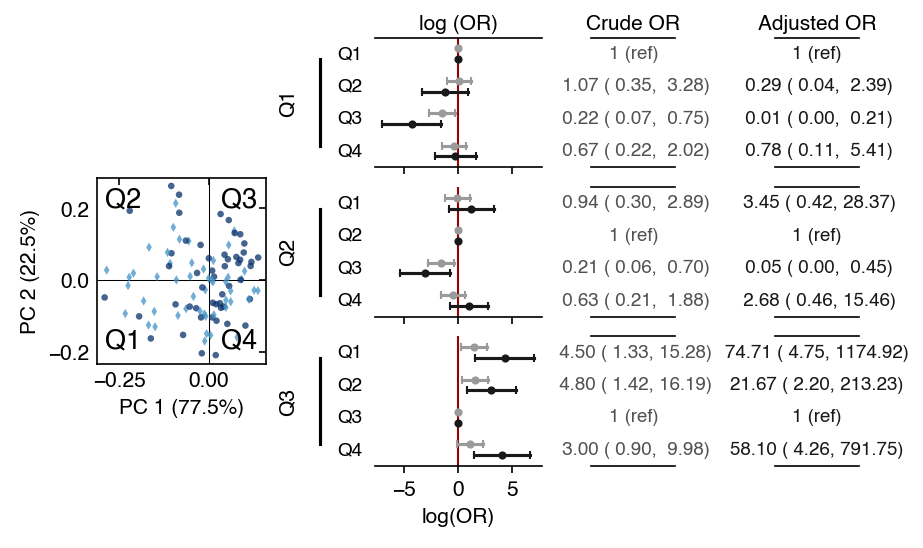

In [46]:
fig_s2 = plt.figure(constrained_layout=True, 
                   dpi=150, 
                   facecolor='None', 
                   figsize=(6,3.5)
                   )
figs2_1, figs2_2 = fig_s2.subfigures(1, 2, width_ratios=[2/7, 5/7], wspace=0)
figs2_1.set_facecolor('None')
figs2_2.set_facecolor('None')

ax_m = figs2_1.add_subplot(111, aspect=1)
sn.scatterplot(
    x='pc0', 
    y='pc1',
    hue='long_survival', 
    data=sample_coords_reg, 
    palette={0: '#4292c6', 1: '#08306b'},
    style='long_survival',
    markers={0: 'd', 1: 'o'},
    edgecolor='None',
    alpha=0.75,
    s=10, 
    legend='brief',
    ax=ax_m)
leg_ = ax_m.legend_
leg_.set_visible(False)
ax_m.yaxis.set_tick_params(labelleft=True, left=False, right=True, tickdir='in')
ax_m.xaxis.set_tick_params(labelbottom=True, left=False, right=True, tickdir='in')

ax_m.set_ylabel('PC 2 ({:1.1f}%)'.format(rpca_coords.proportion_explained[1] * 100))
ax_m.set_xlabel('PC 1 ({:1.1f}%)'.format(rpca_coords.proportion_explained[0] * 100))

xlimm = ax_m.get_xlim()
ylimm = ax_m.get_ylim()

ax_m.plot(xlimm, [0, 0], 'k-', linewidth=0.5, zorder=-1000)
ax_m.plot([0, 0], ylimm, 'k-', linewidth=0.5, zorder=-1000)
ax_m.set_xlim(xlimm)
ax_m.set_ylim(ylimm)

ax_m.text(xlimm[0] + np.diff(xlimm) * 0.05, ylimm[0] + np.diff(ylimm) * 0.05, 
          "Q1", size=13, ha='left', va='bottom')
ax_m.text(xlimm[0] + np.diff(xlimm) * 0.05, ylimm[0] + np.diff(ylimm) * 0.95, 
          "Q2", size=13, ha='left', va='top')
ax_m.text(xlimm[0] + np.diff(xlimm) * 0.95, ylimm[0] + np.diff(ylimm) * 0.05, 
          "Q4", size=13, ha='right', va='bottom')
ax_m.text(xlimm[0] + np.diff(xlimm) * 0.95, ylimm[0] + np.diff(ylimm) * 0.95,
          "Q3", size=13, ha='right', va='top')


gs2 = figs2_2.add_gridspec(3, 5)
for i in np.arange(0, 3):
    levels = (np.hstack([i, np.arange(0, 4)[np.arange(0, 4) != i]]) + 1).astype(int).astype(str)
    raw_fit = fit_pc_axis(f'C(pc_quartile, levels=levels)', ref_eqs['crude'],
                          sample_coords_reg)['summary']
    adj_fit = fit_pc_axis(f'C(pc_quartile, levels=levels)', ref_eqs['model 2'],
                          sample_coords_reg)['summary']
    
    
    for fit in [raw_fit, adj_fit]:
        fit.rename({i: i.split(')')[1] for i in fit.index}, inplace=True)
        fit.drop(columns=['model', 'covar'], inplace=True)
        fit.loc['[T.{}]'.format(i+1)] = np.array([0, np.nan, np.nan, np.nan, np.nan])
        fit.sort_index(inplace=True, ascending=True)
                
    if i == 0:
        ax_label = figs2_2.add_subplot(gs2[i, 0])
        ax_or = figs2_2.add_subplot(gs2[i, 1:3], sharey=ax_label)
        ax_raw = figs2_2.add_subplot(gs2[i, 3], sharey=ax_label)
        ax_adj = figs2_2.add_subplot(gs2[i, 4], sharey=ax_label)
        ax_or.set_xlabel('log (OR)')
        ax_raw.set_xlabel('Crude OR')
        ax_adj.set_xlabel('Adjusted OR')
        ax_or.xaxis.set_label_position('top')
        ax_raw.xaxis.set_label_position('top')
        ax_adj.xaxis.set_label_position('top')
    else:
        ax_label = figs2_2.add_subplot(gs2[i, 0], sharex=ax_label)
        ax_or = figs2_2.add_subplot(gs2[i, 1:3], sharey=ax_label, sharex=ax_or)
        ax_raw = figs2_2.add_subplot(gs2[i, 3], sharey=ax_label, sharex=ax_raw)
        ax_adj = figs2_2.add_subplot(gs2[i, 4], sharey=ax_label, sharex=ax_adj)

    ax_label.xaxis.set_tick_params(labelbottom=False,  labeltop=False, bottom=False)
    ax_raw.xaxis.set_tick_params(labelbottom=False, labeltop=False, bottom=False)
    ax_adj.xaxis.set_tick_params(labelbottom=False,  labeltop=False, bottom=False)
    ax_or.xaxis.set_tick_params(labelbottom=(i==2),  labeltop=False, bottom=True)

    ax_label.yaxis.set_tick_params(labelleft=False, tickdir='in', left=False, right=False)
    ax_raw.yaxis.set_tick_params(labelleft=False, tickdir='in', left=False, right=False)
    ax_adj.yaxis.set_tick_params(labelleft=False, tickdir='in', left=False, right=False)
    ax_or.yaxis.set_tick_params(labelleft=False, tickdir='in', left=False, right=False)

    ax_or.plot([0, 0], [-2, 10], '#980002', linewidth=1, zorder=-1000)
    ax_or.set_ylim(-2, 10)
    
    ax_or.scatter(
        raw_fit['coeff'],
        (np.arange(0, 4) * 3)[::-1],
        color='#9a9a9a',
        s=8.5,
        )
    ax_or.scatter(
        adj_fit['coeff'],
        (np.arange(0, 4) * 3)[::-1] - 1,
        color='#191919',
        s=8.5,
        )
    ax_or.plot(raw_fit[['ci_lo', 'ci_hi']].T,
               np.vstack([(np.arange(0, 4) * 3)[::-1]] * 2),
               marker='|',
               color='#9a9a9a',
               linewidth=1.5,
               markersize=4,
               )
    ax_or.plot(adj_fit[['ci_lo', 'ci_hi']].T,
               np.vstack([(np.arange(0, 4) * 3)[::-1]] * 2) - 1,
               marker='|',
               color='#191919',
               linewidth=1.5,
               markersize=4,
               )
    ax_label.set_xlim([0, 1])
    ax_raw.set_xlim([-3, 3])
    ax_adj.set_xlim([-3, 3])
    ax_label.plot([0.5, 0.5], [0, 8], 'k-')
    ax_label.text(0, y=-2 + (12 / 2), s=f'Q{i+1}', size=10, ha='left', va='center', rotation=90)

    raw_clean = np.exp(raw_fit).apply(make_pretty_or, axis=1)
    adj_clean = np.exp(adj_fit).apply(make_pretty_or, axis=1)
    for j in np.arange(1, 5):
        ax_label.text(x=1, y=9 - (j-1)*3 - 0.5, s='Q{}'.format(j), ha='right', va='center', size=9)
        ax_raw.text(x=0, y=9-(j-1)*3 - 0.5, s=raw_clean.loc[f'[T.{j}]', ('', 'OR (95% CI)')], 
                    ha='center', va='center', size=9, color='#525252')
        ax_adj.text(x=0, y=9-(j-1)*3 - 0.5, s=adj_clean.loc[f'[T.{j}]', ('', 'OR (95% CI)')], 
                    ha='center', va='center', size=9, color='#191919')
    sn.despine(ax=ax_label, left=True, right=True, top=True, bottom=True)
    sn.despine(ax=ax_raw, left=True, right=True, top=False, bottom=False)
    sn.despine(ax=ax_adj, left=True, right=True, top=False, bottom=False)
    sn.despine(ax=ax_or, left=True, right=True, top=(i != 0), bottom=False)
    
    ax_raw.xaxis.set_tick_params(labeltop=False, labelbottom=False)
    ax_adj.xaxis.set_tick_params(labeltop=False, labelbottom=False)
    
ax_or.set_xlabel('log(OR)')
# ax_or.set_xticklabels(['', '-5', '0', '5', ''], size=9)
# ax_or.get_xticklabels()[1]._horizontalalignment = 'right'
# ax_or.get_xticklabels()[-2]._horizontalalignment = 'left'


fig_s2.savefig('output/figures/tumor_rpca_quadrants_or.png', dpi=300)
fig_s2.savefig('output/figures/tumor_rpca_quadrants_or.pdf', dpi=300)

In [ ]:
fig3 = plt.figure(constrained_layout=True, 
                   dpi=300, 
                   # dpi=150,
                   facecolor='w', 
                   figsize=(6, 5)
                  )
fig3_hi, fig3_lo = fig3.subfigures(2, 1, hspace=0, height_ratios=[3/5, 2/5], wspace=0)
fig3_hi_rpca, fig3_hi_tree = fig3_hi.subfigures(1, 2, wspace=0, hspace=0)
fig3_lo_bp, fig3_lo_or = fig3_lo.subfigures(1, 2, wspace=0, width_ratios=[2/5, 3/5])

pcoa_gs = fig3_hi_rpca.add_gridspec(5, 4)
ax_m = fig3_hi_rpca.add_subplot(pcoa_gs[1:, :-1])
ax_pc0 = fig3_hi_rpca.add_subplot(pcoa_gs[0, :-1], sharex=ax_m)
ax_pc1 = fig3_hi_rpca.add_subplot(pcoa_gs[1:, -1], sharey=ax_m)
# pc_lab = fig3_hi_rpca.add_subplot(pcoa_gs[1, 0:2], facecolor='None')


sn.despine(ax=ax_pc0, left=True, right=True, top=True, bottom=False)
sn.despine(ax=ax_pc1, left=False, right=True, top=True, bottom=True)

sn.scatterplot(
    x='pc0', 
    y='pc1', 
    hue='long_survival', 
    data=sample_coords_reg, 
    palette={0: '#4292c6', 1: '#08306b'},
    style='long_survival',
    markers={0: 'd', 1: 'o'},
    edgecolor='None',
    alpha=0.75,
    s=12.5, 
    legend=False,
    ax=ax_m)
sn.violinplot(
    x=sample_coords_reg['pc0'], 
    y=sample_coords_reg['pc1'] * 0,
    hue=sample_coords_reg['long_survival'], 
    palette={0: '#4292c6', 1: '#08306b'},
    data=sample_coords_reg, 
    orient='h',
    split=True,
    legend=False,
    linewidth=1,
    inner=None,
    ax=ax_pc0,
    )
sn.violinplot(
    x=sample_coords_reg['pc0'] * 0, 
    y=sample_coords_reg['pc1'],
    hue=sample_coords_reg['long_survival'], 
    palette={0: '#4292c6', 1: '#08306b'},
    data=sample_coords_reg, 
    orient='v',
    split=True,
    legend=False,
    linewidth=1,
    inner=None,
    ax=ax_pc1
    )
ax_pc0.legend_.set_visible(False)
ax_pc1.legend_.set_visible(False)
ax_pc1.xaxis.set_tick_params(labelbottom=False, bottom=False)
ax_pc1.yaxis.set_tick_params(labelleft=False)
ax_pc0.yaxis.set_tick_params(labelbottom=False, bottom=False)
ax_pc0.xaxis.set_tick_params(labelleft=False)
ax_m.yaxis.set_tick_params(labelleft=False, left=True, right=True, tickdir='in')
ax_m.xaxis.set_tick_params(labelbottom=False, left=True, right=True, tickdir='in')
ax_pc1.set_xlabel('')
ax_pc1.set_ylabel('')
ax_pc0.set_xlabel('')
ax_pc0.set_ylabel('')

ax_m.set_ylabel('PC 2 ({:1.1f}%)'.format(rpca_coords.proportion_explained[1] * 100))
ax_m.set_xlabel('PC 1 ({:1.1f}%)'.format(rpca_coords.proportion_explained[0] * 100))

xlimm = ax_m.get_xlim()
ylimm = ax_m.get_ylim()

ax_m.plot(xlimm, [0, 0], 'k-', linewidth=0.5, zorder=-1000)
ax_m.plot([0, 0], ylimm, 'k-', linewidth=0.5, zorder=-1000)
ax_m.set_xlim(xlimm)
ax_m.set_ylim(ylimm)
ax_m.text(xlimm[0] + np.diff(xlimm) * 0.025,
          0 + np.diff(ylimm) * 0.0125,
          s='left',
          ha='left',
          va='bottom',
          size=8,
          color='#018571',
          )
ax_m.text(xlimm[0] + np.diff(xlimm) * 0.975,
#           ylimm[0] + np.diff(ylimm) * 0.015,
          0 +  np.diff(ylimm) * 0.0125,
          s='right',
          ha='right',
          va='bottom',
          size=8,
          color='#a6611a',
          )
ax_m.text(0 + np.diff(xlimm) * 0.025,
          ylimm[0] + np.diff(ylimm) * 0.025,
          s='bottom',
          ha='left',
          va='bottom',
          size=8,
          color='#7fbf7b',
          )
ax_m.text(0 + np.diff(xlimm) * 0.025,
          ylimm[1] - np.diff(ylimm) * 0.025,
          s='top',
          ha='left',
          va='top',
          size=8,
          color='#762a83',
          )
ax_pc0.set_ylim(ax_pc0.get_ylim()[::-1])
ax_pc0.text(ax_pc0.get_xlim()[0] - np.diff(ax_pc0.get_xlim()) * 0.1, 0, 'A', 
            size=12, va='bottom')

### Includes tree axis
tree_gs = fig3_hi_tree.add_gridspec(5, 7)
tree_ax = fig3_hi_tree.add_subplot(tree_gs[:3, :])
tree_ax.xaxis.set_tick_params(left=False, labelleft=False, right=False, labelright=False)
tree_ax.yaxis.set_tick_params(left=False, labelleft=False, right=False, labelright=False)
tree_ax.text(0.5, 0.5, 'Empress plot', ha='center', va='center')

tree_leg1 = fig3_hi_tree.add_subplot(tree_gs[3:, :4])
tree_leg2 = fig3_hi_tree.add_subplot(tree_gs[3, 4:])
tree_leg3 = fig3_hi_tree.add_subplot(tree_gs[4, 4:])

for ax in [tree_leg1, tree_leg2, tree_leg3]:
    ax.yaxis.set_tick_params(left=False, labelleft=False, length=0)
    ax.xaxis.set_tick_params(left=False, labelleft=False, length=0)
    # sn.despine(ax=ax, left=True, right=True, top=True, bottom=True)

tip_colors = top2['color_group'].unique()
tree_leg1.set_xlim([0, 1])
tree_leg1.set_ylim([0.5, len(tip_colors) + 0.5])
tree_leg1.scatter(
    np.zeros(len(tip_colors)) + 0.05,
    len(tip_colors) - np.arange(0, len(tip_colors)),
    c=[tax_colors.mapped_colors[fam] for fam in np.hstack(tax_order2)],
    marker='s',
    s=12,
    edgecolor='None',
)
for i, group in enumerate(np.hstack(tax_order2)):
    tree_leg1.text(0.1,
                   len(tip_colors) - i,
                   group.replace('__', '. '),
                   size=7,
                   ha='left',
                   va='center',
                   )


tree_leg3.set_xlim(0, 1)
tree_leg3.set_ylim(-0.5, 3.5)

tree_leg3.scatter(
    np.hstack([np.array([0.05] * 3)]),#, np.array([0.55] * 3)]),
    np.hstack([2 - np.arange(0, 3)] * 1),
    c=np.hstack([['#5AB4AC', '#8C510A', '#F5F5F5'], 
                 # ['#762a83', '#7fbf7b', '#f7f7f7'],
                 ]),
    s=12,
    edgecolors=np.array(['None', 'None', 'k'] * 2),
    linewidths=0.5,
    marker='s',
)
tree_leg3.text(0.1, 2, 'Left', ha='left', va='center', size=7)
tree_leg3.text(0.1, 1, 'Right', ha='left', va='center', size=7)
tree_leg3.text(0.1, 0, 'Neither', ha='left', va='center', size=7)
tree_leg3.text(0.6, 2, 'Top', ha='left', va='center', size=7)
tree_leg3.text(0.6, 1, 'Bottom', ha='left', va='center', size=7)
tree_leg3.text(0.6, 0, 'Neither', ha='left', va='center', size=7)
tree_leg3.text(0.25, 3, 'PC 1', size=8, ha='center', va='center', weight='bold')
tree_leg3.text(0.75, 3, 'PC 2', size=8, ha='center', va='center', weight='bold')

gs_alr = fig3_lo_bp.add_gridspec(1, 2)
for i, alr in enumerate(['pc0_alr', 'pc1_alr']):
    ax_alr = fig3_lo_bp.add_subplot(gs_alr[i])
    sn.boxplot(x='long_survival',
               y=alr,
               data=sample_coords_reg,
               palette={0: '#4292c6', 1: '#08306b'},
               linewidth=1,
               fliersize=0,
               width=0.5,
               ax=ax_alr,
               orient='v',
               boxprops={'facecolor': 'w'},
               )
    sn.stripplot(x='long_survival',
                 y=alr,
                 data=sample_coords_reg,
                 palette={0: '#4292c6', 1: '#08306b'},
                 edgecolor=None,
                 s=2.5,
                alpha=0.8,
                ax=ax_alr,
                 orient='v',
                )
    ax_alr.set_xticklabels(['short', 'long'])
#     ax_alr.yaxis.get_label().set_visible(False)
    ax_alr.xaxis.get_label().set_visible(False)
    ax_alr.xaxis.set_tick_params(bottom=False, labelsize=8, length=0)
    ax_alr.yaxis.set_tick_params(left=True, labelsize=8)
    ax_alr.set_ylabel('ALR({0})'.format({'pci': "TSI"}.get(alr.split("_")[0], f'PC {i + 1}')),
                     size=8,
                     )
    sn.despine(ax=ax_alr, left=False, right=True, top=True, bottom=True)
    ax_alr.set_xlim(-0.75, 1.5)
    
ax_alr0, ax_alr1 = fig3_lo_bp.axes

ax_alr0.text(x=ax_alr0.get_xlim()[0] + 0.025,
             y=ax_alr0.get_ylim()[0],
             s=' left', 
             color='#018571',
             ha='left',
             va='bottom',
             size=8,
             rotation=90,
             )
ax_alr0.text(x=ax_alr0.get_xlim()[0] + 0.025, 
            y=ax_alr0.get_ylim()[1],
            s='right', 
            color='#a6611a',
            ha='left',
            va='top',
            size=8,
            rotation=90,
            )
ax_alr1.text(x=ax_alr1.get_xlim()[0] + 0.025, 
             y=ax_alr1.get_ylim()[1],
             s='top', 
             color='#762a83',            
             ha='left',
             va='top',
             size=8,
             rotation=90,
             )
ax_alr1.text(x=ax_alr1.get_xlim()[0] + 0.025, 
             y=ax_alr1.get_ylim()[0],
             s='bottom', 
             color='#7fbf7b',
             ha='left',
             va='bottom',
             size=8,
             rotation=90,
             )

ax_alr0.text(-2, ax_alr0.get_ylim()[1], 'C', size=12)
ax_alr1.text(-2, ax_alr1.get_ylim()[1], 'D', size=12)



### Odds ratio plot
gs_or = fig3_lo_or.add_gridspec(1, 5)
ax_lab = fig3_lo_or.add_subplot(gs_or[:, 0], facecolor='None')
ax_or = fig3_lo_or.add_subplot(gs_or[:, 1:-2], sharey=ax_lab)
ax_crude = fig3_lo_or.add_subplot(gs_or[:, -2], sharey=ax_lab, facecolor='None')
ax_adj = fig3_lo_or.add_subplot(gs_or[:, -1], sharey=ax_lab, facecolor='None')

ypos = np.vstack([
    np.array([4, 3, 1, 0, -2, -3, -4, -6, -7, -8]) * 3 + 1.5*(1-0),
    np.array([4, 3, 1, 0, -2, -3, -4, -6, -7, -8]) * 3 + 1.5*(1-1),
])#.mean(axis=0)

raw_data = pd.concat(axis=0, objs=[halves['crude'], alr3['crude']])
adj_data = pd.concat(axis=0, objs=[halves['model 3'], alr3['model 2']])

def tidy_or(x):
    if pd.isnull(x).any():
        return '1 (ref)'
    else:
        return '{coeff:>3.2f} ({ci_hi:>3.2f}, {ci_lo:>3.2f})'.format(**(np.exp(x)).to_dict())
raw_data['tidy'] = raw_data.apply(tidy_or, axis=1)
adj_data['tidy'] = adj_data.apply(tidy_or, axis=1)
ax_or.plot([0, 0], [ypos.min() - 1.5, ypos.max() + 1.5], 
           '-', color='#980002', linewidth=1)
ax_or.set_ylim([ypos.min() - 1.5, ypos.max() + 1.5])

for i, (data, color, y) in enumerate(zip(*([raw_data, adj_data], ['#919191', '#191919'], ypos))):
#     data.drop(index=['pc1 alr'], level='pc', inplace=True)
    ax_or.plot(
        data[['ci_hi', 'ci_lo']].T,
        np.vstack([y] * 2),
        marker='|',
        color=color,
        markersize=5,
        linewidth=1.25,
    )
    ax_or.plot(
        data['coeff'],
        y,
        marker='o',
        markersize=4,
        linewidth=0,
        color=color
    )
for line in ax_or.get_lines():
    line._capstyle = 'butt'

for (data, ax_mod, txt_color) in zip(*([raw_data, adj_data], [ax_crude, ax_adj], 
                                        ['#525252', '#191919'])):
    for y, ser in zip(*(ypos.mean(axis=0), data['tidy'].values)):
        ax_mod.text(x=0.5, 
                    y=y, 
                    s=ser,
                    ha='center', 
                    va='center', 
                    color=txt_color, 
                    size=8)
        
labels = np.hstack([['left', 'right'], ['bott', 'top'], 
                    np.hstack([['low', 'med', 'high']] * 2)])
for y, label in zip(*(ypos.mean(axis=0), labels)):
    ax_lab.text(0.975, y, label, ha='right', va='center', size=7)
yticks = np.hstack([
    np.hstack([ypos.mean(axis=0)[i*2:(i+1)*2].mean() for i in np.arange(2)]),
    np.hstack([ypos.mean(axis=0)[4+i*3:4+(i+1)*3].mean() for i in np.arange(2)])
])
ylabels = ['PC 1', 'PC 2', 'TSI', 'ALR 2']
ax_lab.set_yticks(yticks)
ax_lab.set_yticklabels(ylabels, rotation=90, size=9, 
                       va='center', ha='center')
ax_lab.yaxis.set_tick_params(left=False, length=0, pad=-8)
for ax in [ax_or, ax_crude, ax_adj, ax_lab]:
    ax.yaxis.set_tick_params(left=False, labelleft=False)
    ax.xaxis.set_tick_params(bottom=False, labelbottom=False)
    sn.despine(ax=ax, left=True, right=True, top=True, bottom=True)
ax_lab.yaxis.set_tick_params(labelleft=True)
# sn.despine(ax=ax_lab, left=False, right=True, top=True, bottom=True)
ax_or.xaxis.set_tick_params(top=True, labeltop=True)
ax_or.set_xticks([-4, -3, -2, -1, 0, 1, -2])
ax_or.set_xticklabels(['-4', '', '-2', '', '0', '', '-2'])
ax_or.plot([-3.95, 0.95], [ax_or.get_ylim()[1]] * 2, 'k-', linewidth=2)

ax_crude.set_title('Crude OR\n(95% CI)', size=9, color='#525252')
ax_adj.set_title('Adj OR\n(95% CI)', size=9, color='#191919')

ax_or.set_xlabel('Log (OR)', size=9)
ax_or.xaxis.set_label_position('top')

ax_lab.set_title('E', size=12, ha='left', loc='left', pad=20)

fig3.savefig('output/figures/figure3_tumor.pdf', facecolor='None')